In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn, Tensor
from sklearn.datasets import make_moons

In [2]:
# It does not have step function
class DiscreteFlow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 128, v: int = 128):
        super().__init__()
        self.v = v
        self.embed = nn.Embedding(v, h)
        self.net = nn.Sequential(
            nn.Linear(dim * h + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim * v))
    
    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        embedded = self.embed(x_t).flatten(1, 2)
        net_input = torch.cat((t[:, None], embedded), -1)
        net_output = self.net(net_input)
        return net_output.reshape(*x_t.shape, self.v)

# Training

In [3]:
batch_size = 256
vocab_size = 128

model = DiscreteFlow(v=vocab_size)
optim = torch.optim.Adam(model.parameters(), lr=0.001) 

for _ in range(10000):
    x_1 = Tensor(make_moons(batch_size, noise=0.05)[0])
    x_1 = torch.round(torch.clip(x_1 * 35 + 50, min=0.0, max=vocab_size - 1)).long()
    
    x_0 = torch.randint(low=0, high=vocab_size, size=(batch_size, 2))

    t = torch.rand(batch_size)

    x_t = torch.where(torch.rand(batch_size, 2) <  t[:, None], x_1, x_0)

    logits = model(x_t, t)
    loss = nn.functional.cross_entropy(logits.flatten(0, 1), x_1.flatten(0, 1)).mean()
    optim.zero_grad()
    loss.backward()
    optim.step()

In [15]:
x_t = torch.randint(low=0, high=vocab_size, size=(200, 2))
t = 0.0
output =model(x_t, torch.ones(200) * t)
prob = torch.softmax(output, dim=-1)
one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
u = prob - one_hot_x_t


tensor([[[7.9318e-07, 8.3684e-07, 8.3286e-07,  ..., 6.5282e-05,
          4.0228e-05, 6.0262e-06],
         [9.7026e-07, 8.3439e-07, 7.5428e-07,  ..., 1.0239e-06,
          1.0028e-06, 1.4575e-06]],

        [[1.8342e-06, 1.5552e-06, 2.0944e-06,  ..., 1.5507e-04,
          7.6943e-05, 1.4413e-05],
         [1.3422e-06, 1.5474e-06, 2.1309e-06,  ..., 2.1421e-06,
          2.2228e-06, 2.6650e-06]],

        [[2.2272e-07, 1.8259e-07, 1.8485e-07,  ..., 1.2841e-04,
          6.7564e-05, 3.7474e-06],
         [1.9643e-07, 1.4924e-07, 1.3857e-07,  ..., 1.4634e-07,
          1.7222e-07, 2.1081e-07]],

        ...,

        [[2.4734e-07, 2.3102e-07, 2.2813e-07,  ..., 7.5879e-05,
          2.9430e-05, 4.2122e-06],
         [2.3255e-07, 2.1184e-07, 2.2067e-07,  ..., 2.3700e-07,
          2.6182e-07, 3.3572e-07]],

        [[2.0532e-07, 1.8098e-07, 1.9195e-07,  ..., 1.1616e-04,
          3.2192e-05, 5.6822e-06],
         [2.4438e-07, 1.6714e-07, 1.7091e-07,  ..., 2.4412e-07,
          2.1496e-07, 2

# Sampling

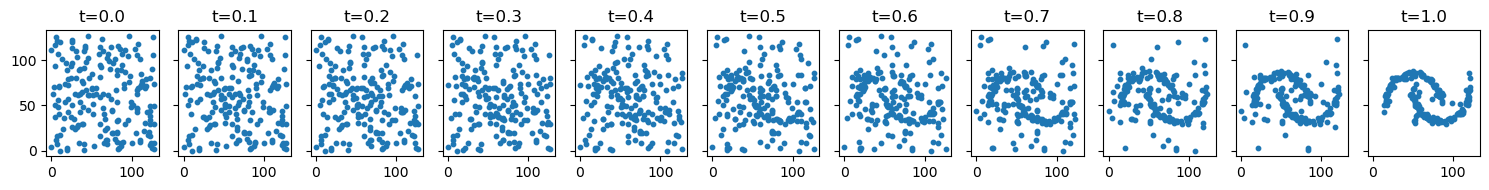

In [16]:
# We need to read for discrete flowmatching to understand this:
x_t = torch.randint(low=0, high=vocab_size, size=(200, 2))
t = 0.0
results = [(x_t, t)]
while t < 1.0 - 1e-3:
    p1 = torch.softmax(model(x_t, torch.ones(200) * t), dim=-1)
    h = min(0.1, 1.0 - t)
    one_hot_x_t = nn.functional.one_hot(x_t, vocab_size).float()
    u = (p1 - one_hot_x_t) / (1.0 - t) 
    x_t = torch.distributions.Categorical(probs=one_hot_x_t + h * u).sample()
    t += h
    results.append((x_t, t))

fig, axes = plt.subplots(1, len(results), figsize=(15, 2), sharex=True, sharey=True)

for (x_t, t), ax in zip(results, axes):
    ax.scatter(x_t.detach()[:, 0], x_t.detach()[:, 1], s=10)
    ax.set_title(f't={t:.1f}')

plt.tight_layout()
plt.show()